# TRƯỜNG ĐẠI HỌC SƯ PHẠM KỸ THUẬT TP. HCM
## KHOA CÔNG NGHỆ THÔNG TIN
### BỘ MÔN KỸ THUẬT DỮ LIỆU

# Đề tài:
# ỨNG DỤNG PHƯƠNG PHÁP THỐNG KÊ VÀ HỌC MÁY DỰ ĐOÁN GIÁ NÔNG SẢN

<p>Họ và tên Sinh viên 1 : Huỳnh Hạo Nhị MSSV 1: 20133006 <p>
<br/>
Họ và tên Sinh viên 2 : Võ Hoài Thương MSSV 2: 20133012

### ARIMA model cho dự đoán giá lúa tổng hợp

In [164]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV

from statsmodels.tsa.api import VAR
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

# Dữ liệu

Dữ liệu giá lúa được chúng tôi sử dụng của tỉnh An Giang, thu thập từ website của Trung
Tâm thông tin Phát triển Nông nghiệp Nông thôn từ 8/3/2007 đến nay.
Tổng quan về dữ liệu, giá lúa có nhiều biến động nhưng giữ được mức khá ổn định từ
năm 2012 đến cuối 2023. Từ đầu năm 2024 đến nay, dữ liệu giá lúa có xu hướng tặng
mạnh so với trước đây.

In [165]:
RICE_QUANTITY_URI = "https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/Lua/gia_lua_xang.csv"

In [166]:
var_file_name = 'var_gia_lua_xang.joblib'
varma_file_name = 'varma_gia_lua_xang.joblib'


In [167]:
df = pd.read_csv(RICE_QUANTITY_URI)

In [168]:
df.set_index('date', inplace=True)

In [169]:
df.head()

,price,area,productivity,quantity,RON 95-III
date,,,,,
8/22/2018,11000,235.0,73.5,1727.4,21.17
8/23/2018,11000,235.0,73.5,1727.4,21.17
8/24/2018,11000,235.0,73.5,1727.4,21.17
8/27/2018,11000,235.0,73.5,1727.4,21.17
8/28/2018,11000,235.0,73.5,1727.4,21.17


<Axes: >

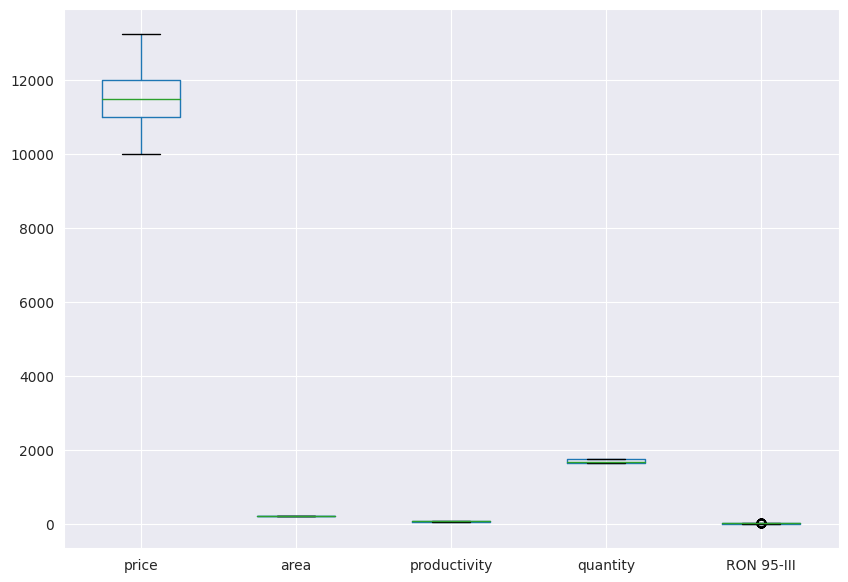

In [170]:
df.boxplot()

In [171]:
# Tính toán ngưỡng cho outlier sử dụng IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Xác định các dòng dữ liệu có giá trị nằm ngoài ngưỡng
outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
print("Số lượng outlier:", len(outliers))

# Kiểm tra và thay đổi giá trị nếu nó nằm ngoài ngưỡng
df.at[df.index[0], 'price'] = min(max(df.iloc[0]['price'], lower_bound), upper_bound)

# Thay thế giá trị của outlier bằng giá trị trước đó
for index, row in outliers.iterrows():
    previous_date_index = df.index.get_loc(index) - 1
    if previous_date_index >= 0:
        previous_date = df.index[previous_date_index]
        previous_value = df.loc[previous_date, 'price']
        df.at[index, 'price'] = previous_value

Số lượng outlier: 0


<Axes: >

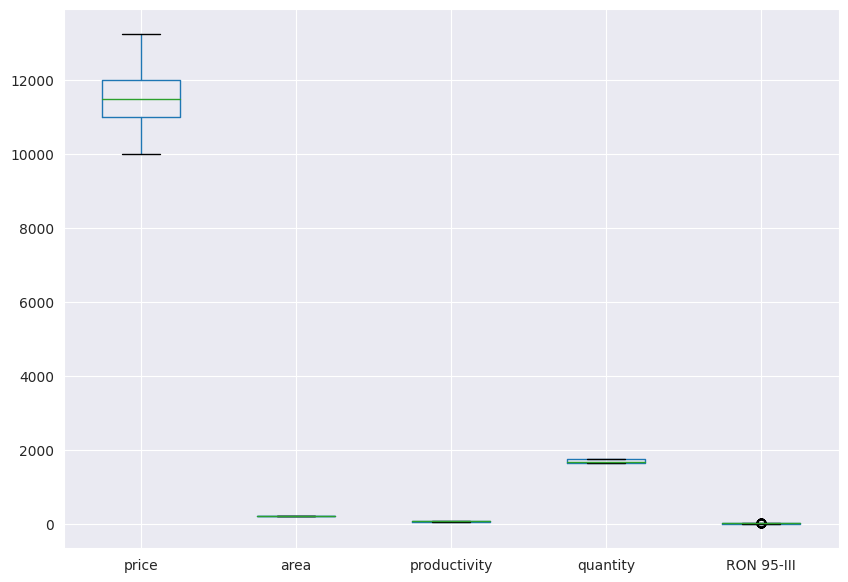

In [172]:
df.boxplot()

In [173]:
df = df.dropna()

In [174]:
# Find the pearson correlations matrix
corr = df.corr(method = 'pearson')
corr

,price,area,productivity,quantity,RON 95-III
price,1.000000,-0.684531,0.510889,0.337576,0.372614
area,-0.684531,1.000000,-0.266361,0.000118,0.103019
productivity,0.510889,-0.266361,1.000000,0.963795,0.269626
quantity,0.337576,0.000118,0.963795,1.000000,0.301301
RON 95-III,0.372614,0.103019,0.269626,0.301301,1.000000


In [175]:
fillter_feature = ['price', 'area', 'productivity', 'quantity', 'RON 95-III']
df = df[fillter_feature]

In [176]:
# Find the pearson correlations matrix
corr = df.corr(method = 'pearson')
corr

,price,area,productivity,quantity,RON 95-III
price,1.000000,-0.684531,0.510889,0.337576,0.372614
area,-0.684531,1.000000,-0.266361,0.000118,0.103019
productivity,0.510889,-0.266361,1.000000,0.963795,0.269626
quantity,0.337576,0.000118,0.963795,1.000000,0.301301
RON 95-III,0.372614,0.103019,0.269626,0.301301,1.000000


<Axes: xlabel='date'>

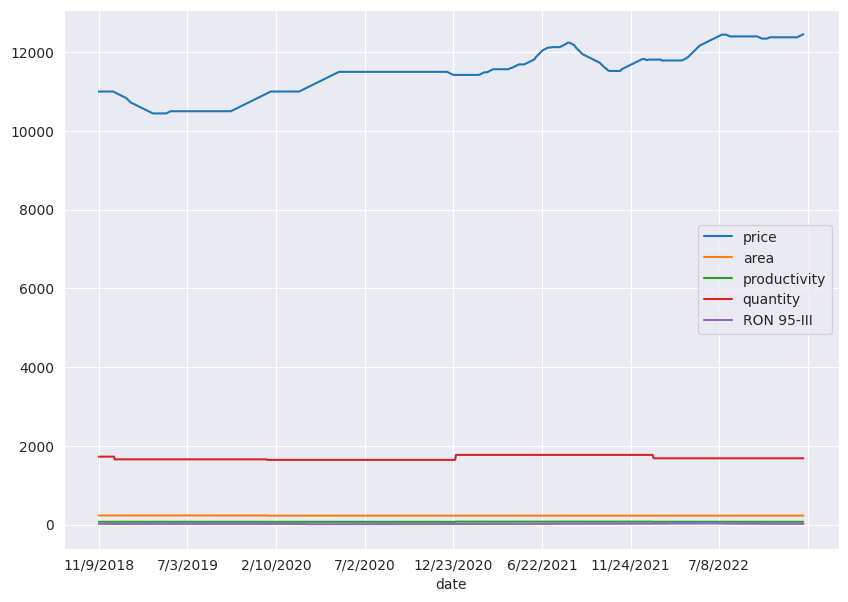

In [177]:
df.price = df.price.rolling(45).mean()
df = df.dropna()
df.plot()

<Axes: xlabel='date'>

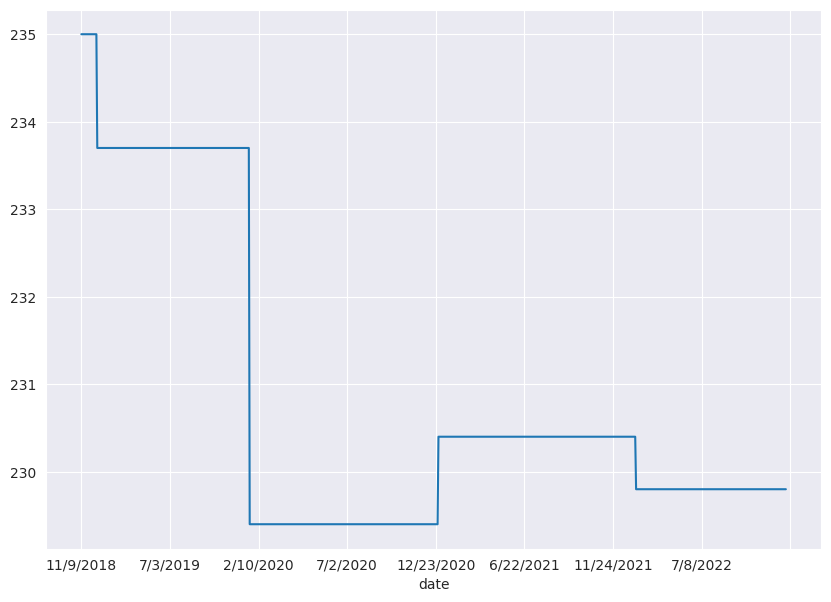

In [178]:
df.area.plot()

In [179]:
nobs = int(len(df) * 0.8)
df_train, df_test = df[0:nobs], df[nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(636, 5)
(160, 5)


In [180]:
from google.colab import files


## Kiểm tra stationary

- Trước khi xây dựng mô hình thống kê, chúng tôi cần thực hiện bước chuẩn bị dữ liệu từ
dữ liệu đã được tiền xử lý. Chúng tôi sẽ tính độ trễ, kiểm tra tính dừng (stationarity) và
lấy sai phân (differencing) để thể hiện được xu hướng và tính mùa vụ hoặc chu kỳ. Tiếp
đến, chúng tôi sử dụng các đồ thị tự tương quan để xác định các bậc p, q của mô hình.
- Trong bước xây dựng mô hình, chúng tôi sẽ kết hợp việc lặp qua các bộ tham số và sử
dụng đồ thị tự tương quan để tìm ra bộ tham số tối ưu với mục tiêu là giá trị Akaike’s
Information Criterion (AIC) nhỏ nhất.
- Dựa trên mô hình với bộ tham số vừa tìm để dự đoán và tính toán hiệu suất của mô hình.

In [181]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [182]:
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.5151
 No. Lags Chosen       = 19
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.526. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "area" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.0578
 No. Lags Chosen       = 0
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.2618. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "productivity" 
    -----------------------------------------------
 Null Hypothesis: Data ha

In [183]:
df_differenced = np.log(df_differenced)
df_differenced = df_differenced.dropna()

In [184]:
df_differenced = df_train.diff().dropna()

In [185]:
df_differenced

,price,area,productivity,quantity,RON 95-III
date,,,,,
11/10/2018,0.000000,0.0,0.0,0.0,0.00
11/12/2018,0.000000,0.0,0.0,0.0,0.00
11/13/2018,0.000000,0.0,0.0,0.0,0.00
11/14/2018,0.000000,0.0,0.0,0.0,0.00
11/15/2018,0.000000,0.0,0.0,0.0,0.00
...,...,...,...,...,...
1/14/2022,0.000000,0.0,0.0,0.0,0.00
1/17/2022,0.000000,0.0,0.0,0.0,0.00
1/18/2022,0.000000,0.0,0.0,0.0,0.00


In [186]:
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.3313
 No. Lags Chosen       = 18
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0135. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "area" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -25.1895
 No. Lags Chosen       = 0
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "productivity" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Le

<Axes: xlabel='date'>

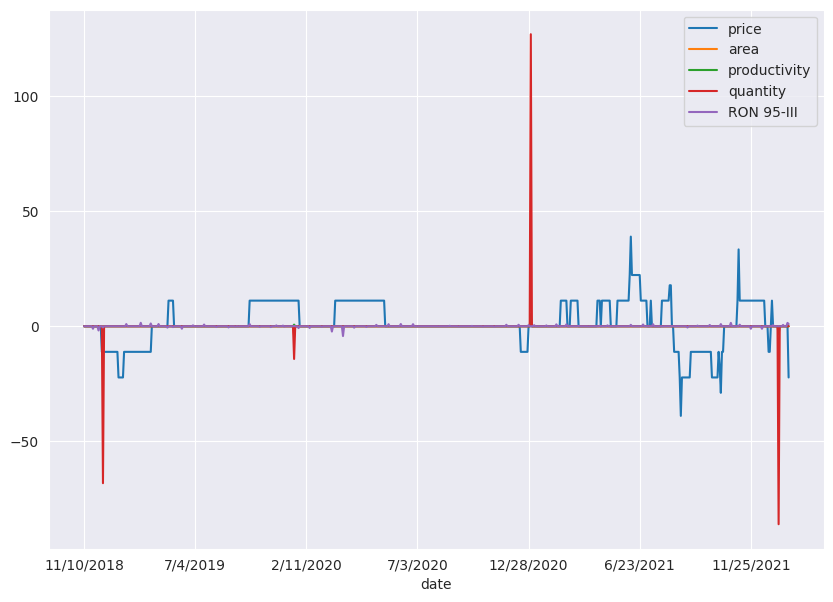

In [187]:
df_differenced.plot()

## Train model

- Chúng tôi sử dụng phương pháp điều chỉnh tham số bằng cách lặp qua các bộ tham số
tương tứng (p, d, q) cho ARIMA
- Việc chọn tham số cần kết hợp với các đồ thị tự tương quan ACF và PACF để chọn
đầu vào tối ưu.
- Tiến hành huấn luyện và chọn mô hình có đánh giá Akaike’s Information Criterion
(AIC) nhỏ nhất.

In [188]:
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_absolute_percentage_error
def forecast_accuracy(forecast, actual):
    mape = mean_absolute_percentage_error(actual, forecast) * 100 # MAPE

    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    return({'mape':mape,'rmse':rmse})

In [189]:
columns_train = fillter_feature

In [190]:
!pip install pmdarima

In [191]:
from pmdarima import auto_arima

In [192]:
arimax = auto_arima(df_differenced.price, exogenous = df_differenced[[ 'area', 'productivity', 'quantity', 'RON 95-III']],
           start_p=1,
           start_q=1,
           max_p=7,
           max_q=7,
            seasonal=False,
          trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3410.627, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4588.888, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3413.096, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4055.916, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3408.792, Time=0.99 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3411.515, Time=0.34 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=3409.782, Time=0.74 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3410.059, Time=0.30 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3408.135, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3794.824, Time=0.15 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=3409.982, Time=0.20 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=3680.523, Time=0.16 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=3402.308, Time=0.85 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=3384.103, Time=2.45 sec
 ARIMA(3,0,2)(0,0,0)[0]          

In [193]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[str(col)+'_forecast'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [194]:
# Forecast
n_periods = len(df_test)
fitted, confint = arimax.predict(n_periods=n_periods,
                                  exogenous=['area', 'productivity', 'quantity', 'RON 95-III'],
                                  return_conf_int=True)


In [195]:
np.square(fitted)

635    397.422503
636    279.732327
637    244.759380
638    302.684538
639    211.676029
          ...    
790      0.423260
791      1.084410
792      0.835987
793      0.656396
794      1.523472
Length: 160, dtype: float64

In [196]:
df_test.index

Index(['2/23/2022', '3/4/2022', '3/7/2022', '3/8/2022', '3/9/2022',
       '3/10/2022', '3/11/2022', '3/14/2022', '3/15/2022', '3/17/2022',
       ...
       '12/5/2022', '12/8/2022', '12/12/2022', '12/13/2022', '12/14/2022',
       '12/19/2022', '12/20/2022', '12/23/2022', '12/26/2022', '12/27/2022'],
      dtype='object', name='date', length=160)

In [209]:
fc_series = pd.DataFrame({'price': fitted.values}, index = df_test.index)

In [210]:
fc_series

,price
date,
2/23/2022,-19.935458
3/4/2022,-16.725200
3/7/2022,-15.644788
3/8/2022,-17.397831
3/9/2022,-14.549090
...,...
12/19/2022,-0.650585
12/20/2022,-1.041350
12/23/2022,0.914323


<Axes: xlabel='date'>

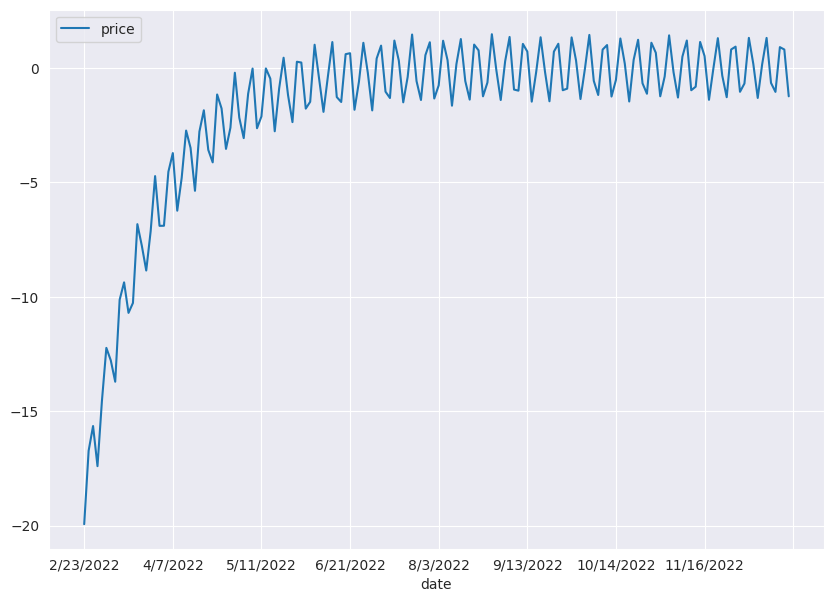

In [211]:
fc_series.plot()

In [212]:
fc_series.price = df_test.price.iloc[0] + fc_series.price.cumsum()

<Axes: xlabel='date'>

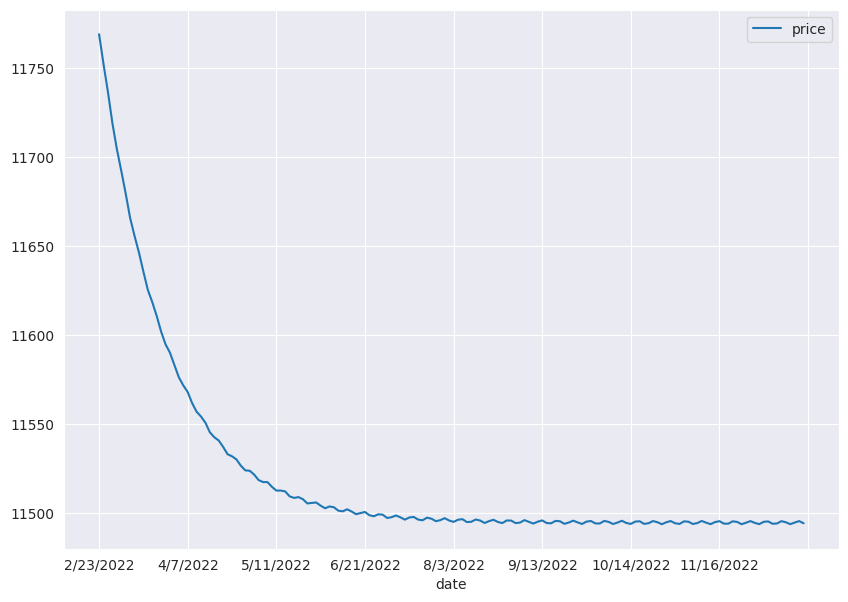

In [213]:
fc_series.plot()

Đánh giá mô hình

In [214]:
accuracy_prod = forecast_accuracy(fc_series['price'].values, df_test['price'].values)
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

mape :  5.8167
rmse :  770.883


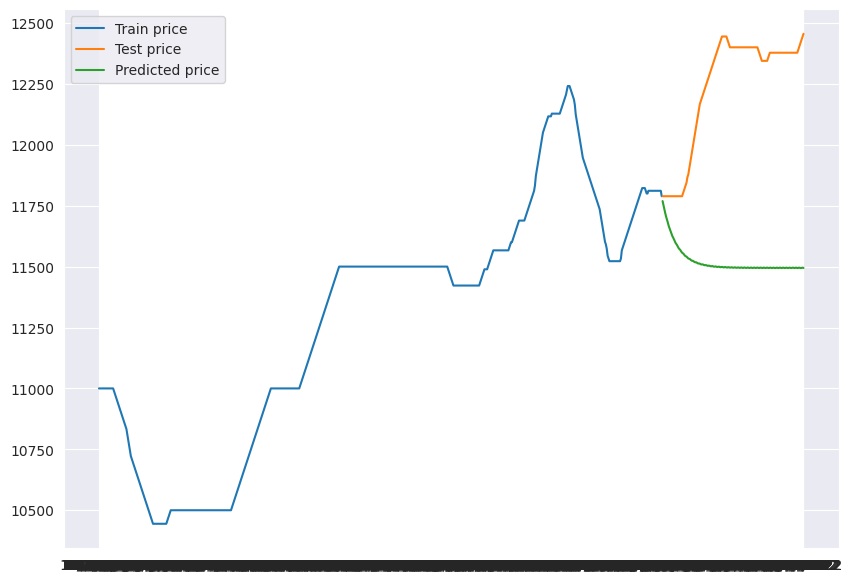

In [215]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in ['price']:

    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(df_train[str(i)], label='Train '+str(i))
    plt.plot(df_test[str(i)], label='Test '+str(i))
    plt.plot(fc_series[str(i)], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

In [ ]:
import joblib
joblib.dump(model_fitted, varma_file_name)
from google.colab import files
files.download(varma_file_name)

Nhận xét:
<br/>
- Các mô hình thống kê có hiệu suất dự đoán khá tốt trên các tập dữ liệu của nông sản
lúa.
- Mô hình hoạt động tốt hơn đối với các dữ liệu có tính chất mùa vụ và các dữ liệu
tương quan cần tìm độ trễ (thời tiết, năng suất, sản lượng) để đánh giá được sự ảnh
hưởng đến giá lúa